In [34]:
##Importing the dependencies
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
labelpath = 'coco.names'
Labels = open(labelpath).read().strip().split("\n")

In [37]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(Labels), 3), dtype="uint8")

In [39]:
##path to weight file and config file
weightspath = 'yolov3.weights'
configpath = 'yolov3.cfg'

In [40]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configpath, weightspath)

[INFO] loading YOLO from disk...


In [66]:
##loading the test image
image1 = cv2.imread('table.jpg')
(H,W) = image1.shape[:2]

In [42]:
##Get only output layers
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [43]:
ln

['yolo_82', 'yolo_94', 'yolo_106']

In [67]:
blob = cv2.dnn.blobFromImage(image1,1/255.0,(416,416),swapRB=True,crop=False)
net.setInput(blob)
start = time.time()
layeroutputs = net.forward(ln)
end = time.time()

In [68]:
print(f'yolo took {(end-start):.6f} seconds to infer')

yolo took 3.939579 seconds to infer


In [69]:
boxes = []
confidences = []
classIDs = []

In [70]:
##lets select bounding boxes
for output in layeroutputs:
    for detections in output:
        scores = detections[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        
        if confidence > 0.15:
            ##getting bounding box co-ordinates
            box= detections[:4] * np.array([W,H,W,H])
            centerX,centerY, width, height = box.astype('int')
            
             # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding bo
            x = int(centerX -(width/2))
            y = int(centerY - (height/2))
            
            
            ##appending bounding boxes, classIDS and confidences
            boxes.append([x,y,int(width),int(height)])
            classIDs.append(classID)
            confidences.append(float(confidence))

In [71]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.6,0.2)


##ensure atleast one detection exist
if len(idxs) > 0:
    
    ##loop over detections
    for i in idxs.flatten():
        
        (x,y) = (boxes[i][0],boxes[i][1])
        (w,h) = (boxes[i][2],boxes[i][3])
        
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image1,(x,y),(x+w,y+h),color,20)
        text = f'{Labels[classIDs[i]]}:{confidences[i]:.4f}'
        y_loc = y+10 if y <10 else y-10
        cv2.putText(image1,text,(x,y_loc),cv2.FONT_HERSHEY_SIMPLEX,3,color,12)

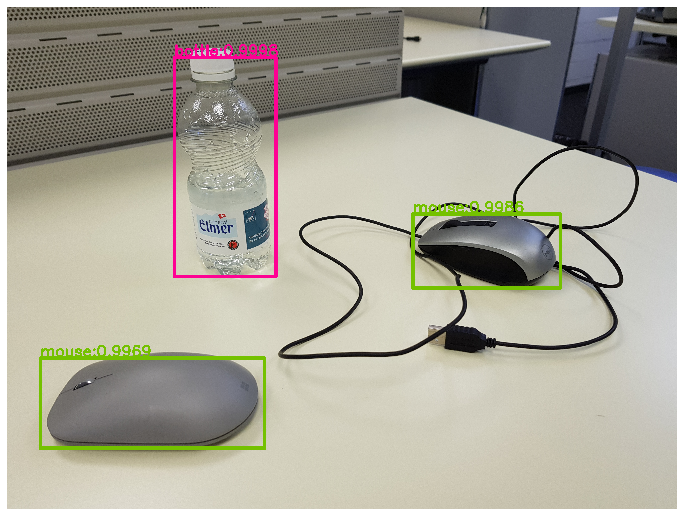

In [72]:
fig = plt.figure(figsize = (12,10))
plt.imshow(image1[:,:,::-1])
plt.axis('off')
plt.savefig('table_yolo.jpg', dpi = 300)